# Trajectory inference for hematopoiesis in mouse

Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

the below sets the figure params (??)
results writes to paul15.h5ad file, which is the head file format. 

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         8.4.0
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
bottleneck                  1.3.2
cffi                        1.15.0
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing    

In [4]:
adata = sc.datasets.paul15() # is this just sample data from the scanpy documentation?

/Users/clairebookworm/opt/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'paul15_clusters' as categorical
Trying to set attribute `._uns` of view, copying.


In [5]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

## Preprocessing and Visualization

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [6]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


In [7]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


*notes on what tl pca is*

`tl.pca` is principal component analysis. it computes PCA coordinates, loadings, and variance decomposition. 
- `zero_center`: if true, compute standard PCA from covar matrix, if false, omit zero-centering variables (which allows to handle sparse input efficiently.) none is auto based on sparseness of data
- `svd_solver`: ARPACK (wrapper in SciPy), randomized (rando algo from halko 2009), auto (chooses auto depending on size of the problem), logpcg (alternative scipy solver)

(svd = single value denominator))

In [8]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:08)


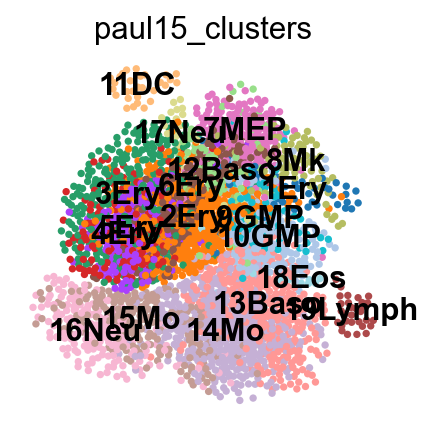

In [9]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This looks pretty messy.

"on data" puts the labels on top of the data

normalizing counts per cell
    finished (0:00:00)


/Users/clairebookworm/opt/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


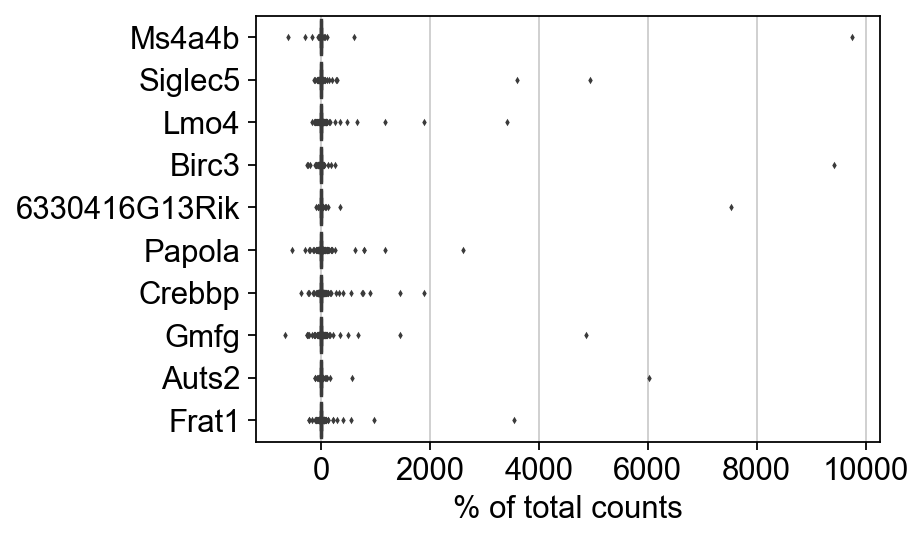

In [10]:
sc.pl.highest_expr_genes(adata, n_top=10, ) # shows the n_top x most expressed genes

This doesn't show because we don't have labels for it? 


## Optional: Denoising the graph

To denoise the graph, we represent it in diffusion map space (and not in PCA space). Computing distances within a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components. It's very similar to denoising a data matrix using PCA. The approach has been used in a couple of papers, see e.g. [Schiebinger et al. (2017)](https://doi.org/10.1101/191056) or [Tabaka et al. (2018)](https://doi.org/10.1101/512582). It's also related to the principles behind MAGIC [Dijk et al. (2018)](https://doi.org/10.1016/j.cell.2018.05.061).

<div class="alert alert-info">

**Note**
    
This is *not* a necessary step, neither for PAGA, nor clustering, nor pseudotime estimation. You might just as well go ahead with a non-denoised graph. In many situations (also here), this will give you very decent results.
    
</div>  

In [11]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap') # what's the x_diffmap? 

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989645  0.9967852  0.9944012  0.98928523
     0.9882635  0.98712564 0.9838318  0.9829755  0.9789324  0.9768993
     0.9744088  0.97278583 0.96618766]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [12]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:09)


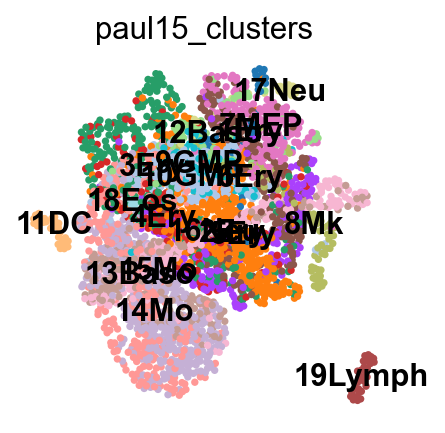

In [13]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This still looks messy, but in a different way: a lot of the branches are overplotted.

## Clustering and PAGA

<div class="alert alert-info">

**Note**

Note that today, we'd use `sc.tl.leiden` - here, we use `sc.tl.louvain` the sake of reproducing the paper results.
    
</div>  

In [14]:
# sc.tl.louvain(adata, resolution=1.0)
sc.tl.leiden(adata, resolution=1.0) # I dont think louvain is in the package at all anymore.

running Leiden clustering
    finished: found 34 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


claire output
```
running Leiden clustering
    finished: found 34 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
```

Note: Leiden clustering is a newer form -> nature paper about how leidan is better than louviain
> community detection is used to understand large and complex networks // algo has a major defect that may yield arbitrarily badly connected communities -- communities might even be disconnected esp when running the algo iteratively. (up to 25% of communities)
**Leiden**
- works faster than Louvain 
- uncovers better partitions

Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [15]:
# sc.tl.paga(adata, groups='louvain')
sc.tl.paga(adata, groups='leiden')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


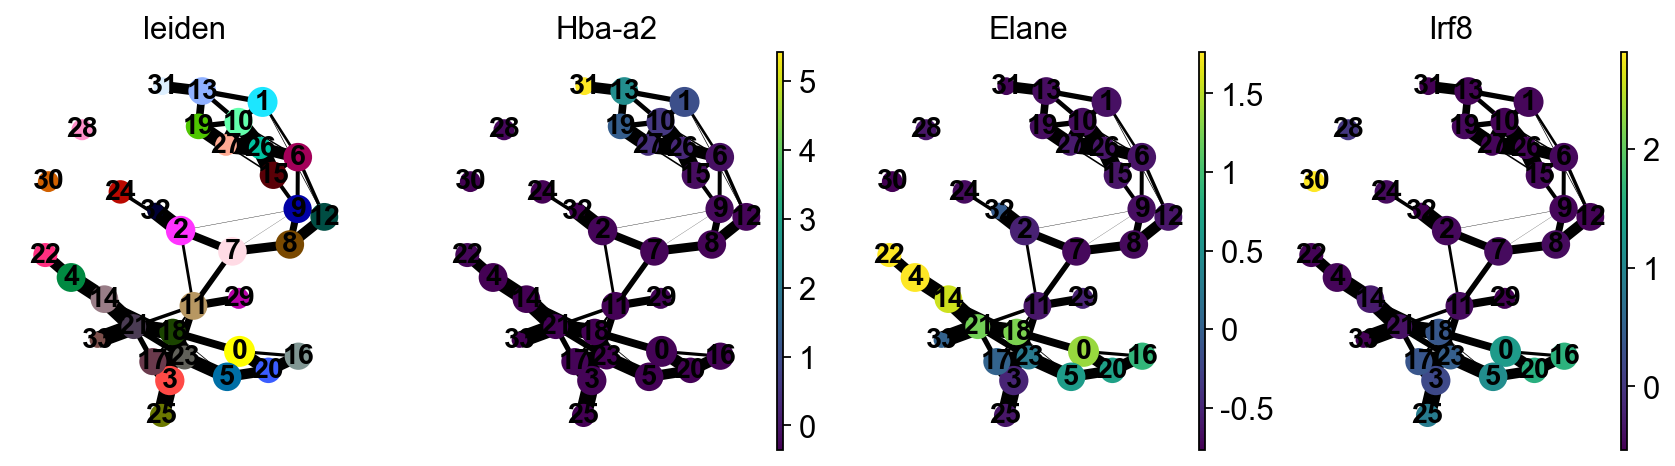

In [16]:
# sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])
sc.pl.paga(adata, color=['leiden', 'Hba-a2', 'Elane', 'Irf8'])

# Hba-a2 is erythroids
# Elane is neutrophils 
# Irf8 is monocytes

--> added 'pos', the PAGA positions (adata.uns['paga'])


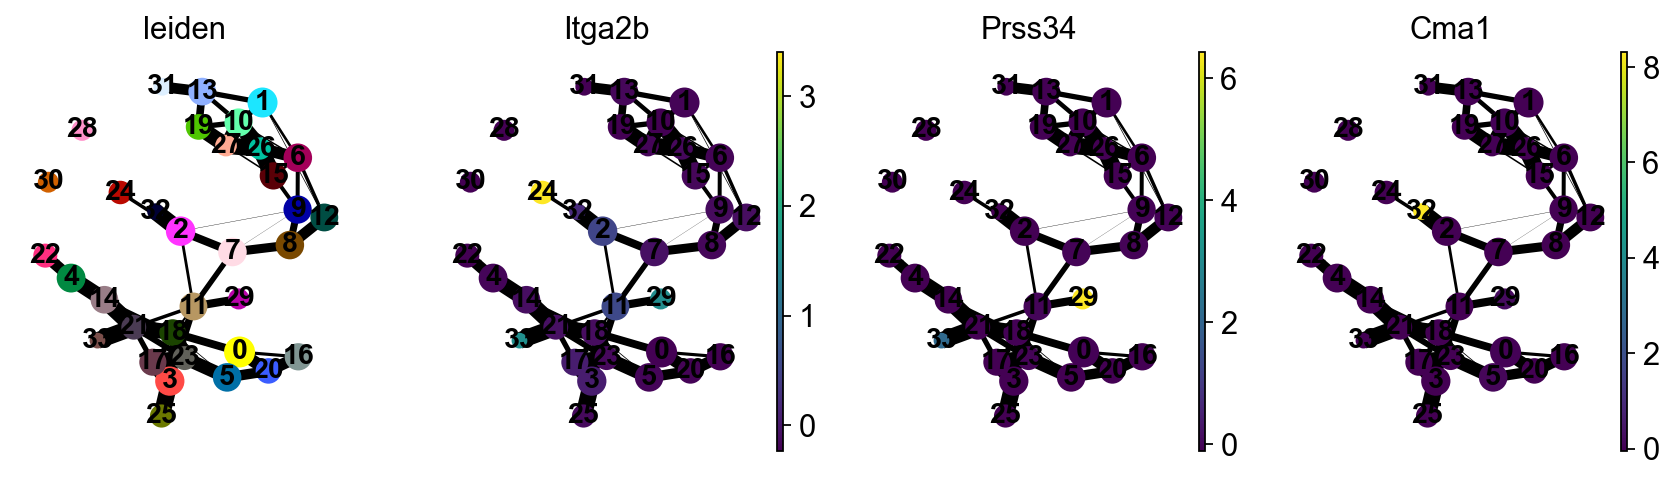

In [17]:
# sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])
sc.pl.paga(adata, color=['leiden', 'Itga2b', 'Prss34', 'Cma1'])


Itga2b = megakaryocytes

Prss34 = basophils

Cma1 = mast cells (the ma?)

Actually annotate the clusters --- note that *Cma1* is a Mast cell marker and only appears in a small fraction of the cells in the progenitor/stem cell cluster 8, see the single-cell resolved plot below.

In [18]:
#adata.obs['louvain'].cat.categories
adata.obs['leiden'].cat.categories

# print(adata.obs['leiden'].cat.categories.size) # it's size 34

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33'],
      dtype='object')

this just numbers the categories for us to reference later?

In [19]:
#adata.obs['louvain_anno'] = adata.obs['louvain']
adata.obs['leiden_anno'] = adata.obs['leiden']
print(adata.obs['leiden'])

0        2
1        0
2       19
3       14
4       19
        ..
2725     6
2726    16
2727     2
2728    14
2729    26
Name: leiden, Length: 2730, dtype: category
Categories (34, object): ['0', '1', '2', '3', ..., '30', '31', '32', '33']


*output* for adata.obs -> what does thsi mean? 
```
0        2
1        0
2       19
3       14
4       19
        ..
2725     6
2726    16
2727     2
2728    14
2729    26
Name: leiden, Length: 2730, dtype: category
Categories (34, object): ['0', '1', '2', '3', ..., '30', '31', '32', '33']
```

*this moves all the obs data from the leiden format and copies to to anno so we can annotate*

In [20]:
adata.obs['leiden_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo', '25', '26', '27', '28', '29', '30', '31', '32', '33']
# the old code only went up to 24 (needed 34 in order to match the categories adata.obs['leiden'].cat.categories)

### scanpy.tl.leiden
(this is from the documentation, whatever the examples here had)
cluster cells into subgroups
requires `neighbors()` or `bbknn()` having run first 

- adjacency = sparse adjacency matrix of graph
- directed = is the graph directed
- use_weights = edges in graph are weighted
- neighbors_key = neighbor connectively as adjacency (any edge?) -> no specified looks at `.obsp['connectivities']`
- obsp = use obsp[obsp] as adjacency

Let's use the annotated clusters for PAGA.

In [21]:
sc.tl.paga(adata, groups='leiden_anno')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


`scanpy.tl.paga`
maps out the course-grained connectivity structures of complex manifolds (from documentation file:///Users/clairebookworm/Documents/scanpy/scanpy.readthedocs.io/en/latest/generated/scanpy.tl.paga.html)

PAGA = **partition-based graph abstraction** -> through quantifying the connectivity of partitions in the single-cell graph, it generals a much simpler abstracted graph (*paga graph*) of partitions -> edge weights rep confidence in the presence of connetions 

`paga()` -> thresholding this confidence here makes better *manifold* data (what's manifold data?)
confience is interpreted as a ratio of the actual vs. expected value of connections (no p-value)

- groups = key for categorical `adata.obs` and you can pass in predefined groups (default is first key of leiden or louvain
- use_rna_velocity = RNA velocity to orient edges (rna velocity?)
= model = version of paga connectivity model

--> added 'pos', the PAGA positions (adata.uns['paga'])


<Axes:>

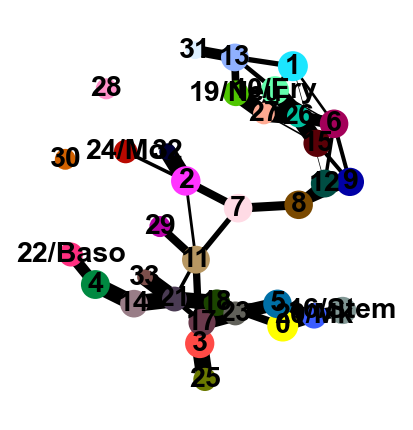

In [22]:
sc.pl.paga(adata, threshold=0.03, show=False)
# making threshold 1 makes all notes unconnected

## Recomputing the embedding using PAGA-initialization

The following is just as well possible for a UMAP.

In [23]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:03)


Now we can see all marker genes also at single-cell resolution in a meaningful layout.

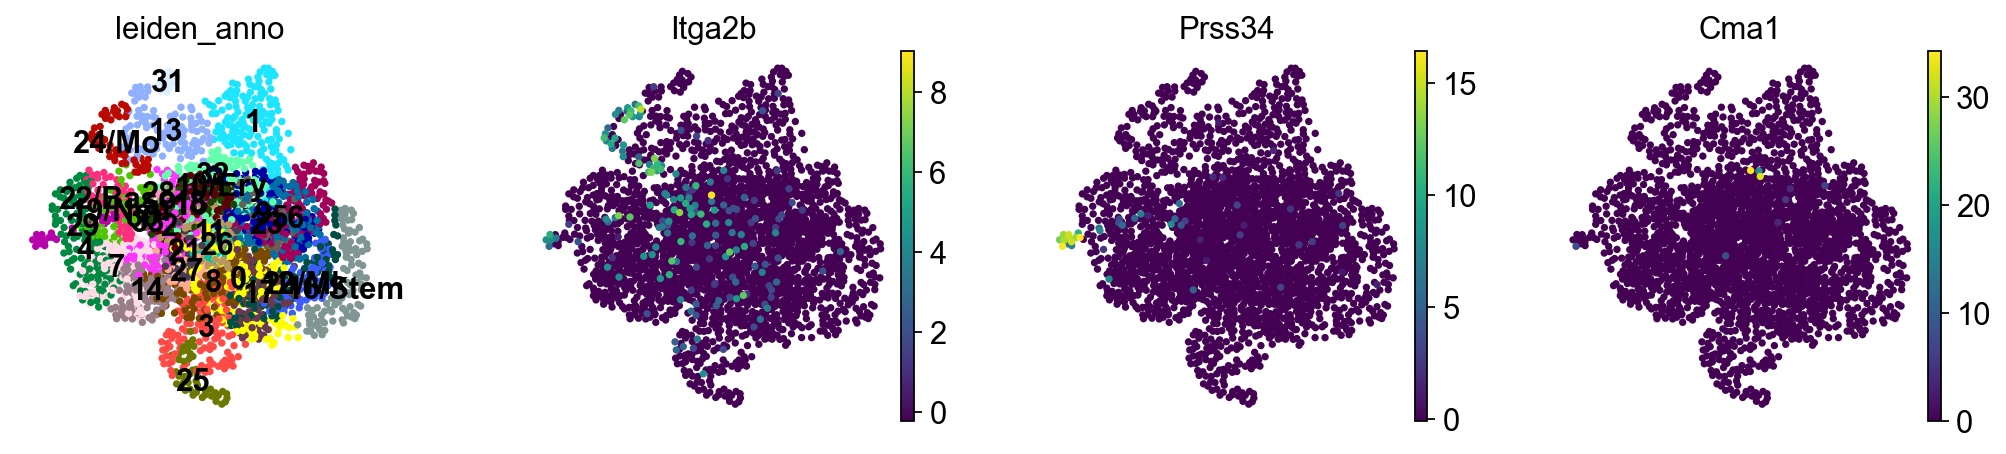

In [24]:
sc.pl.draw_graph(adata, color=['leiden_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

Choose the colors of the clusters a bit more consistently.

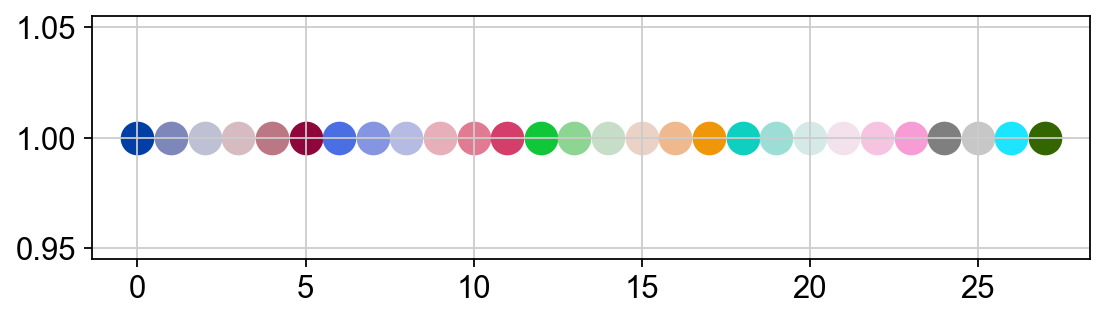

In [25]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200) # s is the radius of the circles 
pl.show()

In [26]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['leiden_anno_colors']) # what's uns? 

In [27]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [28]:
adata.uns['leiden_anno_colors'] = new_colors

And add some white space to some cluster names. The layout shown here differs from the one in the paper, which can be found [here](https://github.com/theislab/paga/blob/f53fcdf4a861b7d3410f8096ffc13a07f1d225c0/blood/paul15/paul15.ipynb). These differences, however, are only cosmetic. We had to change the layout as we moved from a randomized PCA and float32 to float64 precision.

--> added 'pos', the PAGA positions (adata.uns['paga'])


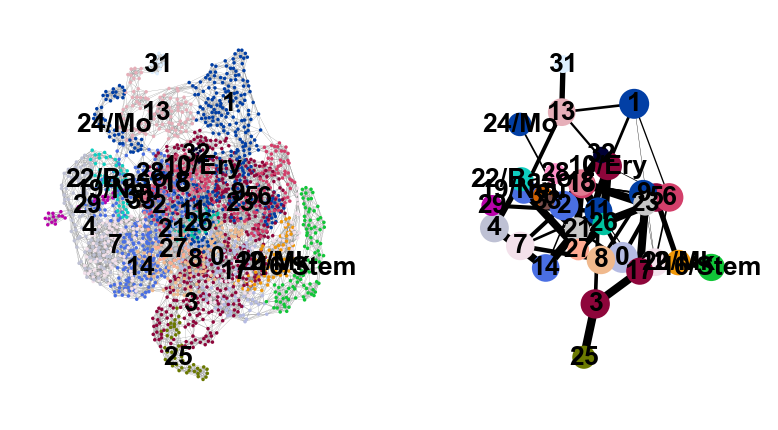

In [29]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

`scanpy.pl.paga_compare` 
scatter and PAGA graph side by side


## Reconstructing gene changes along PAGA paths for a given set of genes

Choose a root cell for diffusion pseudotime.

In [30]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden_anno']  == '16/Stem')[0]

In [31]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Select some of the marker gene names.

In [32]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

Use the full raw data for visualization.

In [33]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

/Users/clairebookworm/opt/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'paul15_clusters' as categorical
Trying to set attribute `._uns` of view, copying.


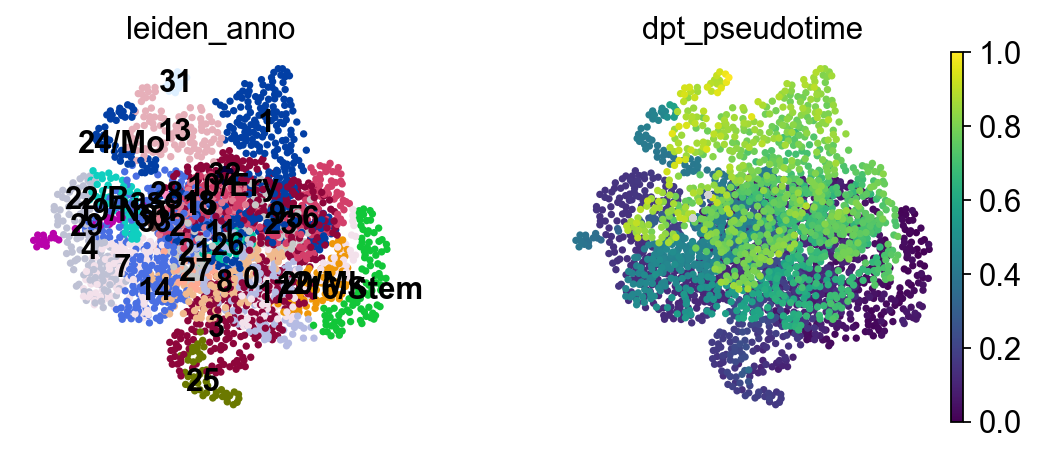

In [34]:
sc.pl.draw_graph(adata, color=['leiden_anno', 'dpt_pseudotime'], legend_loc='on data')

In [35]:
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]
# how are these path numbers decided?

In [36]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [37]:
adata.obs['clusters'] = adata.obs['leiden_anno']  # just a cosmetic change to look nicer

In [38]:
adata.uns['clusters_colors'] = adata.uns['leiden_anno_colors']

In [39]:
!mkdir write

mkdir: write: File exists


/Users/clairebookworm/opt/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1226: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/Users/clairebookworm/opt/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1273: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


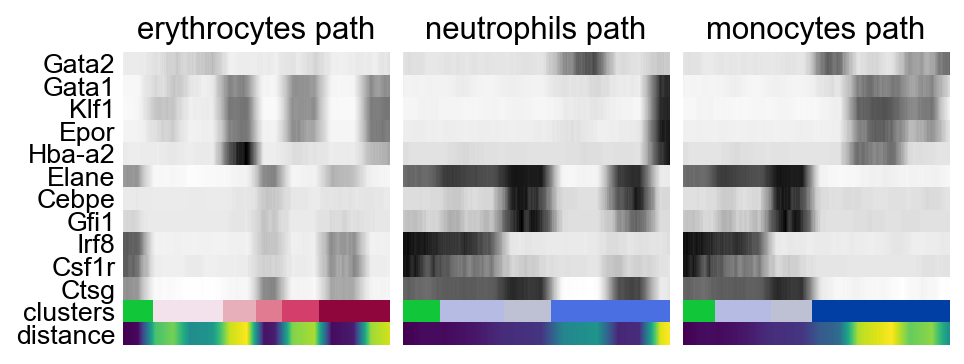

In [40]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()